### Import Libraries

In [43]:
import numpy as np
import torch
import torch.nn as nn
import h5py

import torch.optim as optim
from tqdm.notebook import tqdm
from datetime import datetime


### Import Embeddings

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Helper Code

In [45]:
from torch.utils.data import Dataset

class EmbeddingsDataset(Dataset):

  def __init__(self, file):

    self.f = h5py.File(file, 'r')

    self.embeddings = torch.from_numpy(np.array(self.f['embeddings']))
    self.useful = np.array(self.f['useful_normalised'])


  def __len__(self):

    self.size = self.f['embeddings'].shape[0]
    return self.size

  def __getitem__(self, idx):

    sample = (self.embeddings[idx], self.useful[idx])
    return sample

In [ ]:
FILE_TRAIN = '/content/drive/MyDrive/Own Projects/embeddings-train.h5'
FILE_VALID = '/content/drive/MyDrive/Own Projects/embeddings-valid.h5'
BATCHSIZE_TRAIN = 200
BATCHSIZE_VALID = 20

In [ ]:
train_yelpdata = EmbeddingsDataset(FILE_TRAIN)
valid_yelpdata = EmbeddingsDataset(FILE_VALID)

train_dataloader = torch.utils.data.DataLoader(train_yelpdata, batch_size=BATCHSIZE_TRAIN)
valid_dataloader = torch.utils.data.DataLoader(valid_yelpdata, batch_size=BATCHSIZE_VALID)

print('number of training review embeddings:', len(train_yelpdata))
print('number of validation review embeddings:', len(valid_yelpdata))

number of training review embeddings: 3000
number of validation review embeddings: 400


### Define neural network layers

In [54]:
class Toplayers(nn.Module):

  def __init__(self):
    super().__init__()

    self.linear1 = nn.Linear(768, 384)
    self.linear2 = nn.Linear(384, 384)
    self.linear3 = nn.Linear(384, 1)

    self.batchnorm1 = nn.BatchNorm1d(384)
    self.batchnorm2 = nn.BatchNorm1d(384)


  def forward(self, X):

    X = torch.relu(self.linear1(X))
    X = self.batchnorm1(X)
    X = torch.relu(self.linear2(X))
    X = self.batchnorm2(X)
    X = torch.sigmoid(self.linear3(X))

    return X.squeeze()

model = Toplayers()
model

Toplayers(
  (linear1): Linear(in_features=768, out_features=384, bias=True)
  (linear2): Linear(in_features=384, out_features=384, bias=True)
  (linear3): Linear(in_features=384, out_features=1, bias=True)
  (batchnorm1): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Model Training

In [55]:
EPOCHS = 20
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [56]:
number_of_batches_train = len(train_dataloader)
number_of_batches_valid = len(valid_dataloader)

dt = datetime.now().strftime("%Y-%m-%d %H-%M-%S")

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):

  ### training ###

  train_loss = 0

  model.train()

  for embeddings, useful in tqdm(train_dataloader, desc=f'Epoch {epoch+1} - training', total=number_of_batches_train):     # total = progress bar for specified number of iterations (this case, all batches)
    embeddigs, useful = embeddings.to(device), useful.to(device)

    predictions = model(embeddings)
    loss = criterion(predictions, useful)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss.item()

  torch.cuda.empty_cache()

  train_loss = train_loss / len(train_yelpdata)
  train_losses.append(train_loss)

  ### validation ###

  with torch.no_grad():

    model.eval()

    valid_loss = 0
    best_valid_loss = np.Inf

    for embeddings, useful in tqdm(valid_dataloader, desc=f'Epoch {epoch+1} - validation', total=number_of_batches_valid):
      embeddigs, useful = embeddings.to(device), useful.to(device)

      predictions = model(embeddings)
      loss = criterion(predictions, useful)

      valid_loss += loss.item()

  torch.cuda.empty_cache()

  valid_loss = valid_loss / len(valid_yelpdata)
  valid_losses.append(valid_loss)

  print(f'EPOCH {epoch+1}: \t\t training loss = {train_loss} \t\t validation loss = {valid_loss}')

  if valid_loss <= best_valid_loss:
    checkpoint_file = f'/content/drive/MyDrive/Own Projects/trainingcheckpoint-{dt}-{epoch+1}-{train_loss}-{valid_loss}.pth'
    print('SAVING CHECKPOINT', checkpoint_file)
    torch.save(model.state_dict(), checkpoint_file)
    best_valid_loss = valid_loss



Epoch 1 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 1: 		 training loss = 0.000990223879615466 		 validation loss = 0.008848902583122254
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-1-0.000990223879615466-0.008848902583122254.pth


Epoch 2 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 2: 		 training loss = 0.0007727717061837515 		 validation loss = 0.007110964730381966
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-2-0.0007727717061837515-0.007110964730381966.pth


Epoch 3 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 3: 		 training loss = 0.0005957095523675283 		 validation loss = 0.006152569446712732
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-3-0.0005957095523675283-0.006152569446712732.pth


Epoch 4 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 4: 		 training loss = 0.0003951281706492106 		 validation loss = 0.004055535327643156
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-4-0.0003951281706492106-0.004055535327643156.pth


Epoch 5 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 5: 		 training loss = 0.00022534254069129627 		 validation loss = 0.0035972401313483717
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-5-0.00022534254069129627-0.0035972401313483717.pth


Epoch 6 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 6: 		 training loss = 0.00014798100416858992 		 validation loss = 0.00273320974316448
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-6-0.00014798100416858992-0.00273320974316448.pth


Epoch 7 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 7: 		 training loss = 0.00013019040723641714 		 validation loss = 0.003453655471093953
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-7-0.00013019040723641714-0.003453655471093953.pth


Epoch 8 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 8: 		 training loss = 0.00010135551262646914 		 validation loss = 0.005420586373656988
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-8-0.00010135551262646914-0.005420586373656988.pth


Epoch 9 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 9: 		 training loss = 6.946229096502065e-05 		 validation loss = 0.0029826745809987186
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-9-6.946229096502065e-05-0.0029826745809987186.pth


Epoch 10 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 10: 		 training loss = 6.380828190594911e-05 		 validation loss = 0.0026149631338194014
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-10-6.380828190594911e-05-0.0026149631338194014.pth


Epoch 11 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 11: 		 training loss = 5.8528109453618525e-05 		 validation loss = 0.0021851092914585025
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-11-5.8528109453618525e-05-0.0021851092914585025.pth


Epoch 12 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 12: 		 training loss = 5.3622246719896794e-05 		 validation loss = 0.002472590641118586
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-12-5.3622246719896794e-05-0.002472590641118586.pth


Epoch 13 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 13: 		 training loss = 5.032246684034666e-05 		 validation loss = 0.002663471740670502
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-13-5.032246684034666e-05-0.002663471740670502.pth


Epoch 14 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 14: 		 training loss = 4.957992490381002e-05 		 validation loss = 0.0024502400495111944
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-14-4.957992490381002e-05-0.0024502400495111944.pth


Epoch 15 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 15: 		 training loss = 4.5207721025993423e-05 		 validation loss = 0.0035394592955708504
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-15-4.5207721025993423e-05-0.0035394592955708504.pth


Epoch 16 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 16: 		 training loss = 4.8916009565194445e-05 		 validation loss = 0.0026084345346316694
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-16-4.8916009565194445e-05-0.0026084345346316694.pth


Epoch 17 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 17: 		 training loss = 5.016728366414706e-05 		 validation loss = 0.002816091920249164
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-17-5.016728366414706e-05-0.002816091920249164.pth


Epoch 18 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 18: 		 training loss = 4.982403991743922e-05 		 validation loss = 0.0021687374648172407
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-18-4.982403991743922e-05-0.0021687374648172407.pth


Epoch 19 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 19: 		 training loss = 5.2443025168031456e-05 		 validation loss = 0.002760756304487586
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-19-5.2443025168031456e-05-0.002760756304487586.pth


Epoch 20 - training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20 - validation:   0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 20: 		 training loss = 4.083929040158788e-05 		 validation loss = 0.00236302500590682
SAVING CHECKPOINT /content/drive/MyDrive/Own Projects/trainingcheckpoint-2023-12-29 15-27-52-20-4.083929040158788e-05-0.00236302500590682.pth


### Visualizing Losses

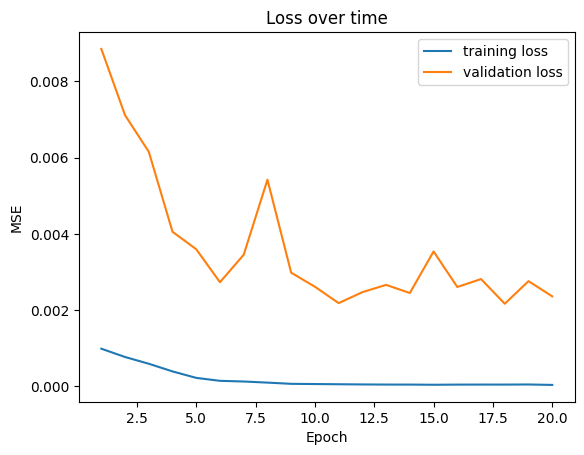

In [65]:
import matplotlib.pyplot as plt

plt.plot(range(1,EPOCHS+1), train_losses, label='training loss')
plt.plot(range(1,EPOCHS+1), valid_losses, label='validation loss')
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

### Test model

Helper Code

In [89]:
def get_results(dataset, batchsize, model):

  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize)
  number_of_batches = len(dataloader)

  predictions = []
  usefulness = []

  model.eval()

  with torch.no_grad():

    for embeddings, useful in tqdm(dataloader, desc='creating predictions', total=number_of_batches):
      embeddings, useful = embeddings.to(device), useful.to(device)

      predictions.extend(model(embeddings).cpu().tolist())
      usefulness.extend(useful.cpu().tolist())


  return np.array(predictions), np.array(usefulness)


In [71]:
FILE_TEST = '/content/drive/MyDrive/Own Projects/embeddings-test.h5'
test_yelpdata = EmbeddingsDataset(FILE_TEST)

In [90]:
train_predictions, train_useful = get_results(train_yelpdata, BATCHSIZE_TRAIN, model)

creating predictions:   0%|          | 0/15 [00:00<?, ?it/s]

In [91]:
test_predictions, test_useful = get_results(test_yelpdata, 40, model)

creating predictions:   0%|          | 0/20 [00:00<?, ?it/s]

### Evaluation

In [79]:
import sklearn.metrics as metrics

METRICS = {
    "Explained Variance": metrics.explained_variance_score,
    "Mean Absolute Error": metrics.mean_absolute_error,
    "Mean Squared Error": metrics.mean_squared_error,
    "Mean Squared Log Error": metrics.mean_squared_log_error,
    "R2": metrics.r2_score
}

In [101]:
print('Evaluation of the training samples:')

for name, metric in METRICS.items():
  print(f'{name:<30} =>', metric(train_predictions, train_useful))

Evaluation of the training samples:
Explained Variance             => 0.7843650190160439
Mean Absolute Error            => 0.05990286343123686
Mean Squared Error             => 0.00810887650181977
Mean Squared Log Error         => 0.005245597941299728
R2                             => 0.7843645988769156


In [102]:
print('Evaluation of the test samples:')

for name, metric in METRICS.items():
  print(f'{name:<30} =>', metric(test_predictions, test_useful))

Evaluation of the test samples:
Explained Variance             => -2.3288998199968414
Mean Absolute Error            => 0.12583897004064057
Mean Squared Error             => 0.04719724377435403
Mean Squared Log Error         => 0.026912532102807925
R2                             => -2.33885343257559
